In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
import numpy as np


## Ladda in datan

In [2]:
df = pd.read_csv('housing.csv')
df.sort_values(by=['housing_median_age'], ascending = False)
df.head(3)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY


## Data Preprocessing Phase:

Vi börjar med att utforska datan för att få en bättre idé om vad det innehåller för typ av data, hur mycket null-värden vi har etc.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Här kan vi t.ex se att det är endast en kolumn som saknar värden: total_bedrooms, så vi kollar lite närmre på dne här kolumnen senare.

In [4]:
df_without_lat_and_long = df.drop(['latitude','longitude'], axis=1)
df_without_lat_and_long.corrwith(df['median_house_value'], axis=0, drop=False, method='pearson', numeric_only=True)

housing_median_age    0.105623
total_rooms           0.134153
total_bedrooms        0.049686
population           -0.024650
households            0.065843
median_income         0.688075
median_house_value    1.000000
dtype: float64

här ser vi att median_income, föga förvånande, korrelerar starkt med median_house_value

In [5]:
df["income_cat"] = pd.cut(df["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

In [6]:
df["total_bedrooms"].value_counts()

total_bedrooms
280.0     55
331.0     51
345.0     50
343.0     49
393.0     49
          ..
2961.0     1
1915.0     1
1215.0     1
3298.0     1
1052.0     1
Name: count, Length: 1923, dtype: int64

Eftersom det inte rör sig om några stora antal saknade värden ersätter vi dem helt enkelt med medelvärdet för kolumnen.

In [7]:
df["total_bedrooms"].fillna(df["total_bedrooms"].mean(), inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   longitude           20640 non-null  float64 
 1   latitude            20640 non-null  float64 
 2   housing_median_age  20640 non-null  float64 
 3   total_rooms         20640 non-null  float64 
 4   total_bedrooms      20640 non-null  float64 
 5   population          20640 non-null  float64 
 6   households          20640 non-null  float64 
 7   median_income       20640 non-null  float64 
 8   median_house_value  20640 non-null  float64 
 9   ocean_proximity     20640 non-null  object  
 10  income_cat          20640 non-null  category
dtypes: category(1), float64(9), object(1)
memory usage: 1.6+ MB


Vi har en kolumn som inte är av typ float, så vi kollar vilka värden vi har i den kolumnen:

In [8]:
df["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

Vi skulle säkert kunna göra mer med den här kolumnen, men till att börja med så kör vi helt enkelt en one-hot encoding här och droppar original kolumnen

In [9]:
df = pd.get_dummies(df, columns=['ocean_proximity'])
df['ocean_proximity_<1H OCEAN'] = df['ocean_proximity_<1H OCEAN'].astype(int)
df['ocean_proximity_INLAND'] = df['ocean_proximity_INLAND'].astype(int)
df['ocean_proximity_NEAR OCEAN'] = df['ocean_proximity_NEAR OCEAN'].astype(int)
df['ocean_proximity_NEAR BAY'] = df['ocean_proximity_NEAR BAY'].astype(int)
df['ocean_proximity_ISLAND'] = df['ocean_proximity_ISLAND'].astype(int)

Nu kollar vi lite på de numeriska kolumnerna för att se distribution och eventuella outliers. Vi skippar longitude och latitude och plottar ett histogram för varje kolumn:

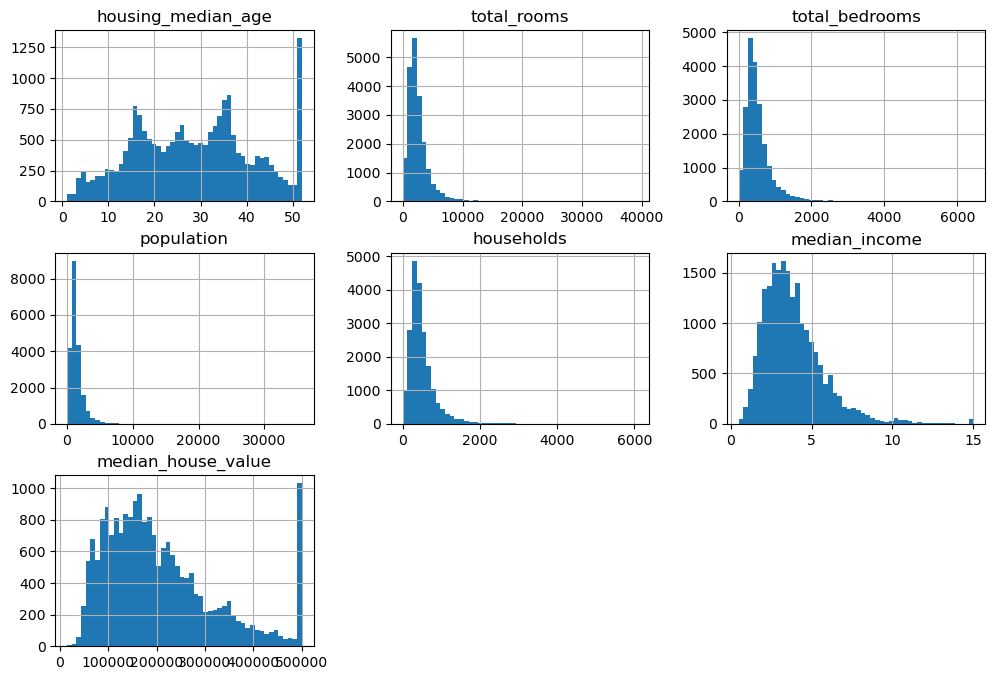

In [10]:
df[["housing_median_age","total_rooms","total_bedrooms","population","households","median_income","median_house_value"]].hist(bins=50,figsize=(12,8))
plt.show()

här ser vi att några kolumner har klippts vid något maxvärde (median_house_age, median_income). Detta måste vi hantera på något sätt senare.

Eftersom vi i slutändan vill prediktera median_house_value, så kollar vi hur de andra attributen korrelerar med detta attribut.

In [11]:
df["income_cat"] = pd.cut(df["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])


In [12]:
import numpy as np
from sklearn.preprocessing import StandardScaler

# Columns that you want to transform
columns_to_transform = ['median_income','total_rooms', 'total_bedrooms',
                        'population', 'households']

# Apply log transformation and standardization
for column in columns_to_transform:
    # Replace 0's with 1's to avoid division by zero
    df[column] = df[column].apply(lambda x: np.log(x+1) if x == 0 else np.log(x))
    
    # Initialize a scaler, then apply it to the features
    scaler = StandardScaler() 
    df[column] = scaler.fit_transform(df[[column]])

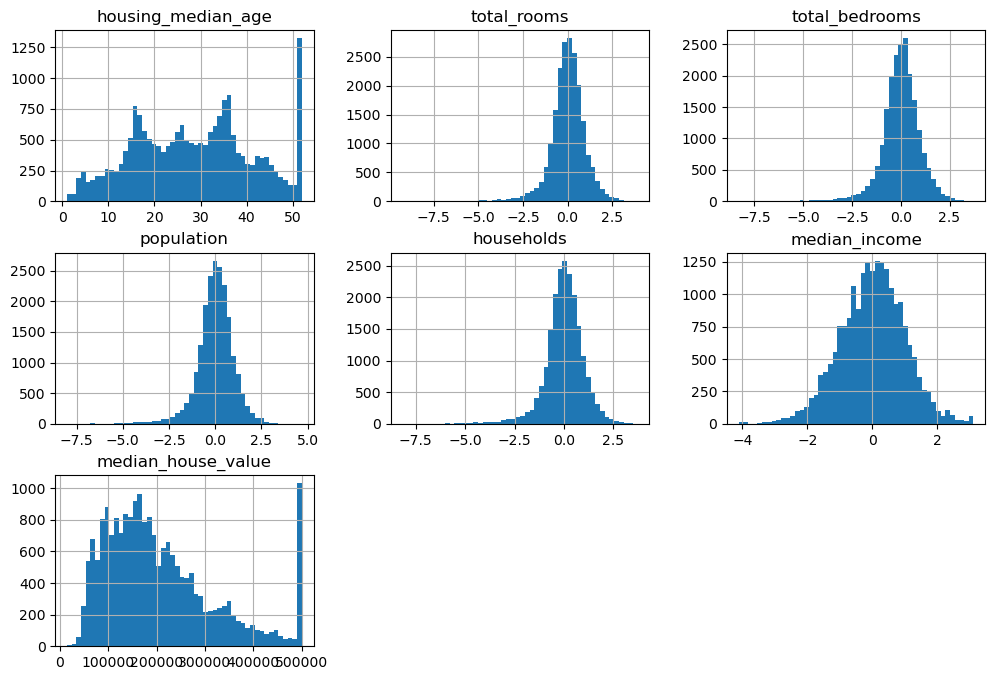

In [13]:
df[["housing_median_age","total_rooms","total_bedrooms","population","households","median_income","median_house_value"]].hist(bins=50,figsize=(12,8))
plt.show()

In [14]:
df['age_was_capped'] = df['housing_median_age'].apply(lambda x: 1 if x >= 50 else 0)
from sklearn.preprocessing import StandardScaler

# Initialize a scaler
scaler = StandardScaler()

# Standardize 'median_house_age' 
df['housing_median_age'] = scaler.fit_transform(df[['housing_median_age']])

In [15]:
from sklearn.model_selection import train_test_split

features_to_drop = ["median_house_value"]
features = df.drop(features_to_drop, axis=1)
target = df['median_house_value']

X_train, X_test,y_train, y_test = train_test_split(
    features, target, test_size=0.2, stratify=df["income_cat"], random_state=42)

# then we remove the income_cat column as we don't need it anymore
for set_ in (X_train, X_test):
    set_.drop("income_cat", axis=1, inplace=True)

X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16512 entries, 12655 to 19773
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   longitude                   16512 non-null  float64
 1   latitude                    16512 non-null  float64
 2   housing_median_age          16512 non-null  float64
 3   total_rooms                 16512 non-null  float64
 4   total_bedrooms              16512 non-null  float64
 5   population                  16512 non-null  float64
 6   households                  16512 non-null  float64
 7   median_income               16512 non-null  float64
 8   ocean_proximity_<1H OCEAN   16512 non-null  int32  
 9   ocean_proximity_INLAND      16512 non-null  int32  
 10  ocean_proximity_ISLAND      16512 non-null  int32  
 11  ocean_proximity_NEAR BAY    16512 non-null  int32  
 12  ocean_proximity_NEAR OCEAN  16512 non-null  int32  
 13  age_was_capped              1651

In [21]:
"""
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [100, 200,300,400,500], 'max_features': [8,10]},
  ]

rf = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='neg_root_mean_squared_error', verbose=2)

grid_search.fit(X_train, y_train)


# Display the best parameters
print(f"Best parameters: {grid_search.best_params_}")

# Display the best score
print(f"Best score: {grid_search.best_score_}")
"""


'\nfrom sklearn.ensemble import RandomForestRegressor\nfrom sklearn.model_selection import GridSearchCV\n\nparam_grid = [\n    {\'n_estimators\': [100, 200,300,400,500], \'max_features\': [8,10]},\n  ]\n\nrf = RandomForestRegressor(random_state=42)\n\ngrid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring=\'neg_root_mean_squared_error\', verbose=2)\n\ngrid_search.fit(X_train, y_train)\n\n\n# Display the best parameters\nprint(f"Best parameters: {grid_search.best_params_}")\n\n# Display the best score\nprint(f"Best score: {grid_search.best_score_}")\n'

In [19]:
from sklearn.metrics import mean_squared_error
rf_model = RandomForestRegressor(n_estimators=500, max_features = 8, random_state=42)
#fit the model
rf_model.fit(X_train, y_train)
#predict
predictions = rf_model.predict(X_test)
mse = mean_squared_error(y_test,predictions, squared=False)
print(f'MSE: {mse}')

MSE: 46580.821316305475


In [20]:
# Evaluate the model
from sklearn.metrics import mean_squared_error

rmse = mean_squared_error(y_test, predictions, squared=False)
print(f'RMSE: {rmse}')

RMSE: 46580.821316305475
